In [1]:
import pandas as pd

In [2]:
dataset_path = "C:/Users/stuti/Documents/CS410/Comparative-sentiment-analysis/IMDBDataset.csv"
dataset = pd.read_csv(dataset_path)
# rename the Column names to Text and Sentiment
dataset.columns = ['Text', 'Sentiment']
# remove the rows with missing values
dataset = dataset.dropna()


dataset.head()

,Text,Sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Process the text

In [3]:
import pandas as pd
import requests
from io import StringIO
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import string
from collections import Counter
import tqdm
import re
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import PorterStemmer as ps
def process_text(text):
     # transform to lower case
    text = text.lower()
    # get the sentence with the most number of words
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove excess white spaces from the text and get words list
    words_list = word_tokenize(text)
    # Remove stopwords
    stop_words = stopwords.words('english')
    words_list = [word for word in words_list if word not in stop_words]
    # join words seperated by whitespace
    modified_text = ' '.join(words_list)
    return modified_text, words_list

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stuti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stuti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
# retain only 1000 random rows from the dataset
dataset = dataset.sample(1000)
# reset the index
dataset = dataset.reset_index(drop=True)
dataset.head()

,Text,Sentiment
0,This was a disappointing film. The people seem...,negative
1,"Some of the secondary actors try, really hard....",negative
2,The banter and humorous rescue scene help to m...,positive
3,Man On Fire tells a story of an ex-special for...,positive
4,The Class is a comedy series that portrays a b...,negative


In [5]:
# for each review, process the text
for i in range(len(dataset)):
    dataset['Text'][i], words_list = process_text(dataset['Text'][i])

C:\Users\stuti\AppData\Local\Temp\ipykernel_14260\3608623935.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset['Text'][i], words_list = process_text(dataset['Text'][i])


In [6]:
print(len(dataset))
true_sentiments = dataset['Sentiment'].values 

1000


## OpenAI sentiment analysis and evaluation

In [8]:
import openai
openai.api_key = 'your-openai-api-key'


In [9]:
import time
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
def analyze_sentiment_openai(text):
    start_time = time.time()
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=f"Analyze the sentiment of the following text: \"{text}\". Is it positive, negative, or neutral?",
        max_tokens=60,
        temperature=0.0  # More deterministic, less creative responses
    )
    end_time = time.time()
    response_time = end_time - start_time
    sentiment = response.choices[0].text.strip().lower()
    return sentiment, response_time



In [52]:
results = []
predicted_labels_openai = []

for true_sentiment, text in zip(true_sentiments, dataset['Text'].tolist()):
    # openai_sentiment, openai_time = analyze_sentiment_openai(text)
    openai_sentiment, openai_time = analyze_sentiment_openai(text)
    
    results.append({
        "Text": text,
        "True Sentiment": true_sentiment,
        "OpenAI Sentiment": openai_sentiment,
        "OpenAI Response Time (s)": openai_time
    })
    
    # predicted_labels_openai.append(openai_sentiment)
    predicted_labels_openai.append(openai_sentiment)

# Convert results to DataFrame for easier analysis and display
results_df = pd.DataFrame(results)
results_df.to_csv("results_openai.csv", index=False)

IBM Watson Precision, Recall, F1-Score: (0.0, 0.0, 0.0, None)
                                                  Text True Sentiment  \
0    madrid able see screener copy film wow gallo a...       Negative   
1    impressed production likely levels production ...       Positive   
2    want gore nothing gore torture youve come righ...       Negative   
3    untom jerry short jerry narrates tale revolves...       Negative   
4    lion king cute story go along lion king basica...       Positive   
..                                                 ...            ...   
995  club scenes film extremely believable tim curr...       Positive   
996  hong kong heartthrob andy lau veteran star chi...       Negative   
997  imagine young people involved making necromanc...       Negative   
998  show terrible get complete waste great talent ...       Negative   
999  went straight big screen view kicker flick kno...       Positive   

    IBM Watson Sentiment  IBM Watson Confidence  IBM Watson R

c:\Users\stuti\Documents\CS410\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\stuti\Documents\CS410\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [122]:
# save the results to a CSV file
# Calculate precision, recall, and F1-score for each model
# metrics_openai = precision_recall_fscore_support(true_sentiments, predicted_labels_openai, average='weighted')
def calculate_metrics(true_sentiments, predicted_labels, output_file_path):

    metrics_openai = precision_recall_fscore_support(true_sentiments, predicted_labels, average='weighted')
    F1_score_openai = 2/(1/metrics_openai[0] + 1/metrics_openai[1])

    # Print metrics
    print("openai Precision:", metrics_openai[0])
    print("openai Recall:", metrics_openai[1])
    print("openai F1-Score:", F1_score_openai)

    # average response time
    average_response_time_openai = results_df['OpenAI Response Time (s)'].mean()
    print("Average Response Time:", average_response_time_openai)
    metrics = {
        "OpenAI Precision": metrics_openai[0],
        "OpenAI Recall": metrics_openai[1],
        "OpenAI F1-Score": F1_score_openai,
        "Average Response Time": average_response_time_openai,
    }
    with open(output_file_path, "w") as f:
        json.dump(metrics, f)




In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def plot(results_df):
    confidence_scores = results_df['OpenAI Confidence'].values
    plt.figure(figsize=(10, 6))
    sns.histplot(confidence_scores, bins=30, kde=True)
    plt.title('Distribution of Confidence Scores for Adversarial Examples')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.show()


In [123]:
calculate_metrics(true_sentiments, predicted_labels_openai, "metrics_openai.json")

IBM Watson Precision: 0.7825395364285543
IBM Watson Recall: 0.742
IBM Watson F1-Score: 0.7617307680851981
Average Response Time: 0.3392541089057922


c:\Users\stuti\Documents\CS410\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


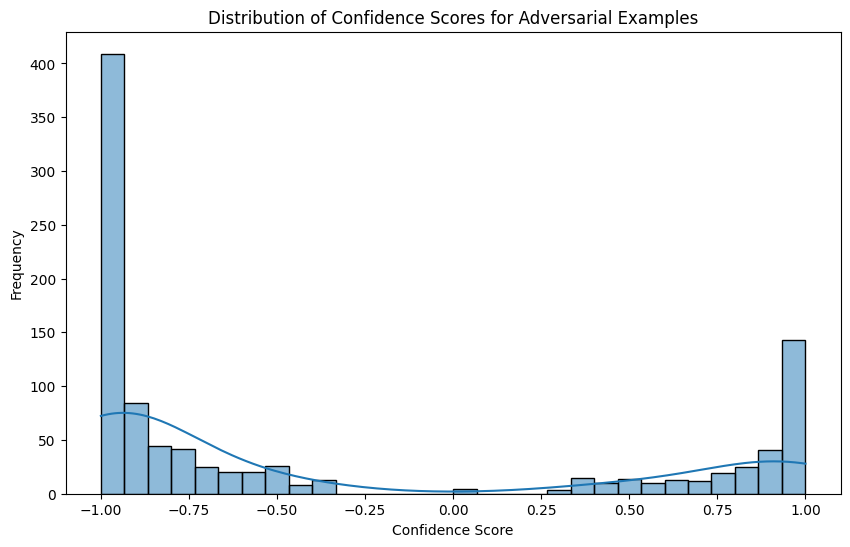

In [109]:
plot(results_df)

## Adversial testing


In [95]:
import random
from nltk.corpus import wordnet

# Ensure nltk resources are available
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

# Function to create a simple adversarial example by replacing words with their synonyms
def synonym_replacement(text, n=1):
    words = text.split()
    n = len(words) // 3
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = set()
        for syn in wordnet.synsets(random_word):
            for lemma in syn.lemmas():
                synonyms.add(lemma.name())
        if len(synonyms) > 1:
            synonyms.discard(random_word)
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
            if num_replaced >= n: # Only replace up to n words
                break
    
    sentence = ' '.join(new_words)
    return sentence

# Select a few texts randomly and create their adversarial examples
sample_texts = dataset['Text']
adversarial_examples = [synonym_replacement(text) for text in sample_texts]

def remove_random_spaces(text, n=1):
    words = text.split()
    n = len(words) // 10
    new_words = words.copy()
    
    for i in range(n):
        random_index = random.randint(0, len(new_words)-1)
        new_words.pop(random_index)
    
    sentence = ' '.join(new_words)
    return sentence

adversarial_examples = [remove_random_spaces(text) for text in sample_texts]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stuti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\stuti\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [97]:
print(adversarial_examples)

['madrid see screener copy film wow gallo amazing unusual performance gives aside genius film however film ever seen life poorly done borders laughable also val kilmer fan part made grand effort view film problem val really one scene name cast lead intelligence rest cast seen stranded directors films films far far average contain interesting vincent performances much gallo fan see film regardless bad like gallo zero left love', 'impressed production likely levels production plot character developmentbr br definitely realism genre since nothing going makes use creative imagination twists manipulating audience viewer shall feel think assesbr actors especially little ones chemistry brother sister blowing maybe even common real movie excellent literally watch visualizing one knows movie good one want end eventually everything', 'want gore nothing youve come right movie want least sliver good acting logic story consistencies even good guy ending go elsewherebr br couldnt help think jeeeez p

In [90]:
results_adversial = []
predicted_labels_openai_adversial = []

for true_sentiment, text in zip(true_sentiments, adversarial_examples):
    # openai_sentiment, openai_time = analyze_sentiment_openai(text)
    openai_sentiment, openai_confidence, openai_time = analyze_sentiment_openai(text)
    
    results_adversial.append({
        "Text": text,
        "True Sentiment": true_sentiment,
        "OpenAI Sentiment": openai_sentiment,
        "OpenAI Response Time (s)": openai_time,
    })
    
    # predicted_labels_openai.append(openai_sentiment)
    predicted_labels_openai_adversial.append(openai_sentiment)

# Convert results to DataFrame for easier analysis and display
results_df_adversial = pd.DataFrame(results_adversial)
results_df_adversial.to_csv("results_openai_adversial.csv", index=False)

In [124]:
calculate_metrics(true_sentiments, predicted_labels_openai_adversial, "metrics_openai_adversial30.json")

IBM Watson Precision: 0.7395723752156268
IBM Watson Recall: 0.665
IBM Watson F1-Score: 0.700306567602669
Average Response Time: 0.3392541089057922


c:\Users\stuti\Documents\CS410\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


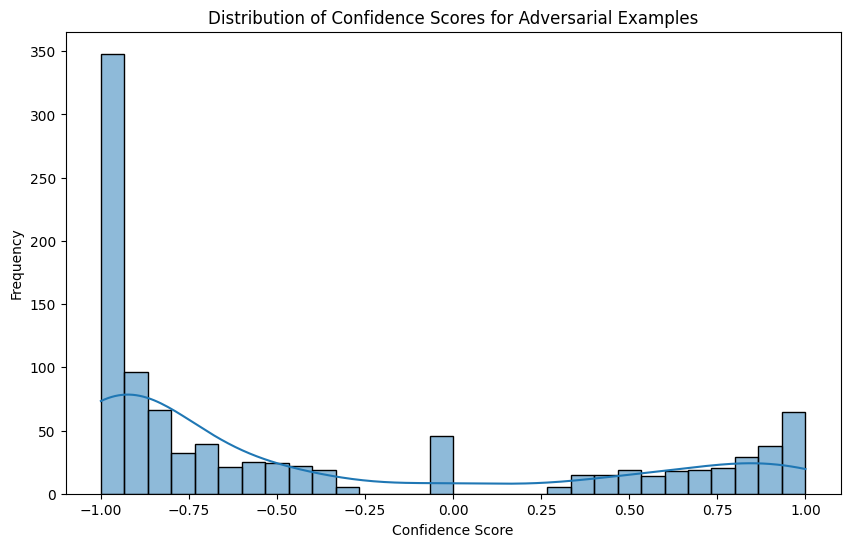

In [125]:
plot(results_df_adversial)

In [113]:
from googletrans import Translator
translator = Translator()

def translate(text):
    translated_text = translator.translate(text, dest='es').text 
    return translated_text


In [114]:
dataset_translated = dataset.copy()

for i in range(len(dataset_translated)):
    dataset_translated['Text'][i] = translate(dataset_translated['Text'][i])



C:\Users\stuti\AppData\Local\Temp\ipykernel_11164\462684534.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset_translated['Text'][i] = translate(dataset_translated['Text'][i])


In [117]:
results_lang = []
predicted_labels_openai_lang = []

for true_sentiment, text in zip(true_sentiments, dataset_translated['Text'].tolist()):
    # openai_sentiment, openai_time = analyze_sentiment_openai(text)
    try:
        openai_sentiment, openai_confidence, openai_time = analyze_sentiment_openai(text)
    except:
        openai_sentiment, openai_confidence, openai_time = 'neutral', 0, 0
    results_lang.append({
        "Text": text,
        "True Sentiment": true_sentiment,
        "OpenAI Sentiment": openai_sentiment,
        "OpenAI Response Time (s)": openai_time,
    })
    
    # predicted_labels_openai.append(openai_sentiment)
    predicted_labels_openai_lang.append(openai_sentiment)

# Convert results to DataFrame for easier analysis and display
results_df_lang = pd.DataFrame(results)
results_df_lang.to_csv("results_openai_lang.csv", index=False)

In [126]:
calculate_metrics(true_sentiments, predicted_labels_openai_lang, "metrics_openai_lang.json")

IBM Watson Precision: 0.693668580615526
IBM Watson Recall: 0.652
IBM Watson F1-Score: 0.6721891572358002
Average Response Time: 0.3392541089057922


c:\Users\stuti\Documents\CS410\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


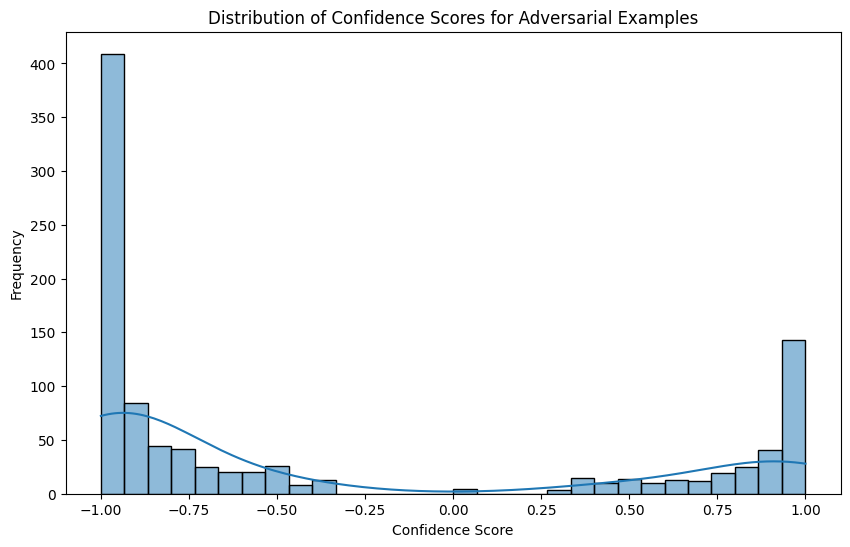

In [127]:
plot(results_df_lang)